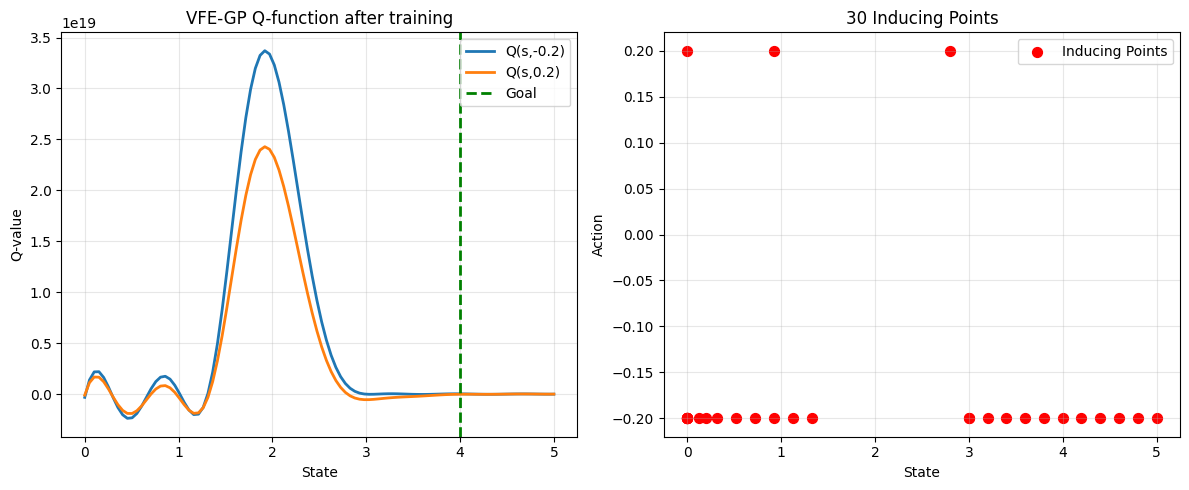

Experience buffer size: 1000
Number of inducing points: 30
Mini-batch size: 32


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel



# Simple 1D environment
class SimpleEnv:
    def __init__(self):
        self.states = np.linspace(0, 5, 50)  # 50 positions
        self.actions = [-0.2, 0.2]           # move left or right
        self.goal = 4.0                      

    def step(self, s, a):
        s_new = s + a
        s_new = np.clip(s_new, self.states[0], self.states[-1])
        r = -abs(self.goal - s_new)  # reward: closer to goal is better
        return s_new, r


# GP with VFE and mini-batch support

class VFE_GP_RL:
    def __init__(self, kernel, n_inducing=30, batch_size=32):
        self.kernel = kernel
        self.n_inducing = n_inducing
        self.batch_size = batch_size
        
        # Inducing points (randomly initialized)
        self.inducing_points = None
        
        # Experience replay buffer
        self.buffer_X = []
        self.buffer_y = []
        self.buffer_size = 1000
        
    def initialize_inducing_points(self, X):
        
        if len(X) > self.n_inducing:
            idx = np.random.choice(len(X), self.n_inducing, replace=False)
            self.inducing_points = X[idx]
        else:
            # Random points if not enough data
            state_range = [X[:, 0].min(), X[:, 0].max()]
            action_range = [X[:, 1].min(), X[:, 1].max()]
            self.inducing_points = np.column_stack([
                np.random.uniform(state_range[0], state_range[1], self.n_inducing),
                np.random.uniform(action_range[0], action_range[1], self.n_inducing)
            ])
    
    def vfe_predict(self, X):
       
        if self.inducing_points is None:
            return np.zeros(len(X)), np.ones(len(X))
        
        # Kernel matrices
        K_uu = self.kernel(self.inducing_points)
        K_uf = self.kernel(self.inducing_points, X)
        K_uu_inv = np.linalg.inv(K_uu + 1e-6 * np.eye(self.n_inducing))
        
        # Mean prediction
        alpha = K_uu_inv @ self.alpha
        mean = K_uf.T @ alpha
        
        # Variance (simplified)
        var = np.diag(self.kernel(X)) - np.diag(K_uf.T @ K_uu_inv @ K_uf)
        
        return mean, var
    
    def vfe_update(self, X_batch, y_batch):
      
        if self.inducing_points is None:
            self.initialize_inducing_points(X_batch)
        
        # Kernel matrices
        K_uu = self.kernel(self.inducing_points)
        K_uf = self.kernel(self.inducing_points, X_batch)
        
        # Add noise for stability
        K_uu += 1e-6 * np.eye(self.n_inducing)
        
        # Compute Q matrix (VFE approximation)
        K_uu_inv = np.linalg.inv(K_uu)
        Q_ff = K_uf.T @ K_uu_inv @ K_uf
        
        # Diagonal matrix for observations
        sigma_n = 1e-3  # Noise level
        D = sigma_n * np.eye(len(X_batch))
        
        # Compute predictive parameters
        Sigma_inv = np.linalg.inv(Q_ff + D)
        self.alpha = K_uu_inv @ K_uf @ Sigma_inv @ y_batch
        
        # Store batch data for future updates
        self.buffer_X.extend(X_batch)
        self.buffer_y.extend(y_batch)
        
        # Keep buffer within size limit
        if len(self.buffer_X) > self.buffer_size:
            self.buffer_X = self.buffer_X[-self.buffer_size:]
            self.buffer_y = self.buffer_y[-self.buffer_size:]
    
    def get_mini_batch(self):
      
        if len(self.buffer_X) < self.batch_size:
            return np.array(self.buffer_X), np.array(self.buffer_y)
        
        idx = np.random.choice(len(self.buffer_X), self.batch_size, replace=False)
        X_batch = np.array([self.buffer_X[i] for i in idx])
        y_batch = np.array([self.buffer_y[i] for i in idx])
        return X_batch, y_batch


# Parameters

gamma = 0.9
episodes = 20
max_steps = 15
batch_size = 32
n_inducing = 30


# Initialize VFE-GP agent

kernel = RBF(length_scale=0.5) + WhiteKernel(noise_level=1e-3)
vfe_gp = VFE_GP_RL(kernel, n_inducing=n_inducing, batch_size=batch_size)


# Training with mini-batch updates

env = SimpleEnv()

for ep in range(episodes):
    s = np.random.choice(env.states)
    
    for step in range(max_steps):
        # Epsilon-greedy action
        if np.random.rand() < 0.2:
            a = np.random.choice(env.actions)
        else:
            if len(vfe_gp.buffer_X) > 0:
                q_vals = []
                for act in env.actions:
                    q, _ = vfe_gp.vfe_predict(np.array([[s, act]]))
                    q_vals.append(q[0])
                a = env.actions[np.argmax(q_vals)]
            else:
                a = np.random.choice(env.actions)

        # Take step
        s_next, r = env.step(s, a)

        # Q-learning target
        if len(vfe_gp.buffer_X) > 0:
            q_next_vals = []
            for act in env.actions:
                q, _ = vfe_gp.vfe_predict(np.array([[s_next, act]]))
                q_next_vals.append(q[0])
            target = r + gamma * np.max(q_next_vals)
        else:
            target = r

       
        vfe_gp.buffer_X.append([s, a])
        vfe_gp.buffer_y.append(target)
        
        # Update with mini-batch every few steps
        if (step % 2 == 0) and (len(vfe_gp.buffer_X) >= batch_size):
            X_batch, y_batch = vfe_gp.get_mini_batch()
            vfe_gp.vfe_update(X_batch, y_batch)

        s = s_next
    
    # Final update at end of episode
    if len(vfe_gp.buffer_X) >= batch_size:
        X_batch, y_batch = vfe_gp.get_mini_batch()
        vfe_gp.vfe_update(X_batch, y_batch)


# Plot learned Q-function

s_plot = np.linspace(0, 5, 100)
q_left = []
q_right = []

for s in s_plot:
    q_left_val, _ = vfe_gp.vfe_predict(np.array([[s, -0.2]]))
    q_right_val, _ = vfe_gp.vfe_predict(np.array([[s, 0.2]]))
    q_left.append(q_left_val[0])
    q_right.append(q_right_val[0])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(s_plot, q_left, label='Q(s,-0.2)', linewidth=2)
plt.plot(s_plot, q_right, label='Q(s,0.2)', linewidth=2)
plt.axvline(env.goal, color='green', linestyle='--', label='Goal', linewidth=2)
plt.xlabel('State')
plt.ylabel('Q-value')
plt.title('VFE-GP Q-function after training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if vfe_gp.inducing_points is not None:
    plt.scatter(vfe_gp.inducing_points[:, 0], vfe_gp.inducing_points[:, 1], 
                color='red', s=50, label='Inducing Points')
plt.xlabel('State')
plt.ylabel('Action')
plt.title(f'{n_inducing} Inducing Points')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Experience buffer size: {len(vfe_gp.buffer_X)}")
print(f"Number of inducing points: {n_inducing}")
print(f"Mini-batch size: {batch_size}")